In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
import itertools
import importlib

In [36]:
from training import toy
importlib.reload(toy)
torch.manual_seed(42)

batch_size = 1

trainset = toy.CubicToyDataset(min=-4, max=4, sample_count=20, noise=3, normalize=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)

device = torch.device("cpu")

In [17]:
import matplotlib.pyplot as plt

def plot(eval):
    plt.xlim(-6, 6)
    plt.ylim(-150, 150)
    t = np.linspace(-6, 6, 50)

    plt.plot(t, trainset.eval_value(t), color="blue") # Actual function

    means, variances = np.zeros(len(t)), np.zeros(len(t))
    with torch.no_grad():
        means, variances = eval(torch.unsqueeze(torch.tensor(t * trainset.x_norm, dtype=torch.float), -1))
        #for i, input in enumerate(t):
         #   mean, variance = eval(torch.tensor([[input]], dtype=torch.float))
          #  means[i], deviations[i] = mean.numpy(), np.sqrt(variance.numpy())
    means = torch.squeeze(means, -1) / trainset.y_norm
    variances = torch.squeeze(variances, -1) / trainset.y_norm**2

    higher_bound = means + 3 * torch.sqrt(variances)
    lower_bound = means - 3 * torch.sqrt(variances)
    plt.plot(t, means, color="red") # Averaged predictions
    plt.fill_between(t, lower_bound, higher_bound, color="lightgrey")
    print(f"RMSE {torch.sqrt(F.mse_loss(means, torch.from_numpy(t**3)))}")

    xs, ys = zip(*((x.numpy() / trainset.x_norm, y.numpy() / trainset.y_norm) for (x, y) in trainloader))
    plt.scatter(xs, ys, s=4, color="blue")

Epoch 0: loss 235.43690490722656
Epoch 10: loss 375.27032470703125
Epoch 20: loss 35.73881912231445
Epoch 30: loss 2.531514883041382
Final loss 0.9999485015869141
RMSE 41.33379304417933


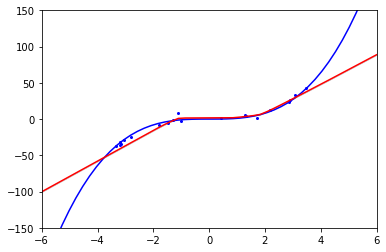

In [21]:
# Point estimator with L2 regularization

torch.manual_seed(42)

model = nn.Sequential(nn.Linear(1, 100), nn.ReLU(), nn.Linear(100, 1))
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=0.001)
for epoch in range(40):
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss {loss}")
print(f"Final loss {loss}")
plot(lambda input: (model(input), torch.tensor(0)))

Epoch 0: loss 235.43690490722656
Epoch 10: loss 375.27032470703125
Epoch 20: loss 35.73881912231445
Epoch 30: loss 2.531514883041382
Final loss 0.9999485015869141
RMSE 26.0212621449277


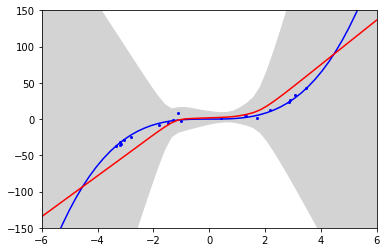

In [26]:
# SWAG trained with Adam and L2 regularization (lr is currently not adjusted for SWAG)

from training import swag
importlib.reload(swag)

torch.manual_seed(42)

model = nn.Sequential(nn.Linear(1, 100), nn.ReLU(), nn.Linear(100, 1))
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=0.001) # Without weight_decay the covariance matrix is not positive definit???
wrapper = swag.SWAGWrapper(model, 1, 10)
for epoch in range(40):
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
    wrapper.update(epoch)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss {loss}")
print(f"Final loss {loss}")

def eval_swag(input):
    return wrapper.sample(input, 100, model, 1)

plot(eval_swag)

Training model 0
  Final loss -3.8164029121398926
Training model 1
  Final loss -4.036062717437744
Training model 2
  Final loss -3.7366280555725098
Training model 3
  Final loss -4.961099147796631
Training model 4
  Final loss -4.1424031257629395
RMSE 31.638889633701996


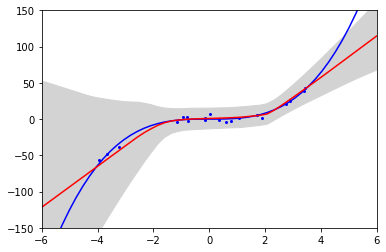

In [48]:
# Ensemble of point estimators with L2 regularization

from training import ensemble
importlib.reload(ensemble)

torch.manual_seed(42)

adversarial_ensemble = True

def nll_loss(mean, variance, target):
    return (torch.log(variance) / 2 + torch.pow(target - mean, 2) / (2 * variance)).sum() / mean.shape[0]

models = [nn.Sequential(nn.Linear(1, 100), nn.ReLU(), nn.Linear(100, 2)) for _ in range(5)]
for i, model in enumerate(models):
    print(f"Training model {i}")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
    for epoch in range(100):
        for data, target in trainloader:
            optimizer.zero_grad()
            data.requires_grad = True
            output = model(data)
            mean, variance = output[:,0], torch.log1p(torch.exp(output[:,1])) + 10e-6
            loss = nll_loss(mean, variance, target)

            if adversarial_ensemble:
                loss.backward(retain_graph = True)
                a_data = data + 0.01 * torch.sign(data.grad)
                optimizer.zero_grad()
                a_target = trainset.eval_value(a_data)
                a_output = model(data)
                a_mean, a_variance = a_output[:,0], torch.log1p(torch.exp(a_output[:,1])) + 10e-6
                a_loss = nll_loss(a_mean, a_variance, a_target)
                loss += a_loss

            loss.backward()
            optimizer.step()
        #if epoch % 10 == 0:
            #print(f"  Epoch {epoch}: loss {loss}")
    print(f"  Final loss {loss}")

importlib.reload(ensemble)
def eval_esemble(input):
    return ensemble.combined_variance_output(input, models)

plot(eval_esemble)

Epoch 0: loss 0.13246774673461914
Epoch 10: loss 0.006681246217340231
Epoch 20: loss 0.0004428375978022814
Epoch 30: loss 0.0032864052336663008
Epoch 40: loss 0.001294333953410387
Epoch 50: loss 0.0004648944013752043
Epoch 60: loss 0.004890623968094587
Epoch 70: loss 0.002356428187340498
Epoch 80: loss 0.0014282778138294816
Epoch 90: loss 0.00030775435152463615
Final loss 5.12031874677632e-06
RMSE 43.59920857916616


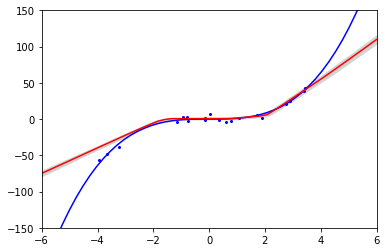

In [59]:
# Bayesian NN (Bayes-by-Backprop)

from training.util import GaussianMixture
import training.bbb as bbb
importlib.reload(bbb)

torch.manual_seed(42)

pi = 0.5 # 0.25, 0.5, 0.75
sigma1 = np.exp(-1) # 0, 1, 2
sigma2 = np.exp(-7) # 6, 7, 8
prior = GaussianMixture(pi, sigma1, sigma2)

model = nn.Sequential(bbb.BayesianLinearLayer(1, 100, prior, prior, device, weight_draw="minibatch"), nn.ReLU(), bbb.BayesianLinearLayer(100, 1, prior, prior, device, weight_draw="minibatch"))

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for epoch in range(100):
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data)
        #mean, variance = output[:,0], torch.log1p(torch.exp(output[:,1])) + 10e-6
        #dist = torch.distributions.Normal(mean, variance)
        log_prior = sum([getattr(layer, "log_prior", 0) for layer in model])
        log_posterior = sum([getattr(layer, "log_posterior", 0) for layer in model])
        loss = (log_posterior - log_prior) / len(trainloader) + F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss {loss}")
print(f"Final loss {loss}")

def eval_bbb(input):
    samples = 10
    outputs = torch.zeros((input.shape[0], samples))
    for i in range(samples):
        outputs[:,i] = torch.squeeze(model(input), -1)
    return torch.mean(outputs, dim=1), torch.var(outputs, dim=1)

plot(eval_bbb)